# Spam Classification with BERT

The aim of this project is a spam detection to get a model to predict if the messages is spam or not. This approach I have used a BERT (Bidirectional Encoder Representations from Transformers) model. In the analysis I have used a Huggingface Transformers library as well.

**Dataset**

The dataset comes from SMS Spam Collection and that can be found at Kaggle.

This SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It comprises one set of SMS messages in English of 5,574 messages, which is tagged acording being ham (legitimate) or spam.

### Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model

import transformers
from transformers import BertTokenizer, TFBertModel

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

First observations:

In [ ]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

In [11]:
df.shape

(5572, 2)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### Data preparation

Remove unnecessary variables:

In [13]:
# df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

Rename columns:

In [14]:
df.rename(columns={'Category': 'Class', 'Message': 'Text'}, inplace=True)

In [15]:
df.head()

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Changing column "Class" to 0 and 1:

- spam = 1
- ham = 0

In [16]:
df['Class'] = df['Class'].map({'ham':0, 'spam':1})
df.head()

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
df['Text'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

Checking for any missing values:

In [18]:
df.isna().sum()

,0
Class,0
Text,0


### EDA and Data Visualization

Checking proportion 'Class' variable:

In [19]:
df['Class'].value_counts()

,count
Class,
0,4825
1,747


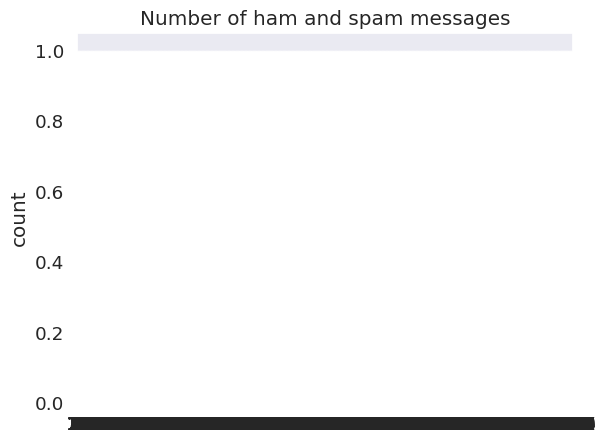

In [20]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.Class).set_title("Number of ham and spam messages")
plt.show()

In [21]:
df.describe()

,Class
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


The target class variable is imbalanced, where "ham" values are more dominating than "spam" ones.

**SMS Distribution**

Checking the percentage of spam SMS and ham SMS messages:

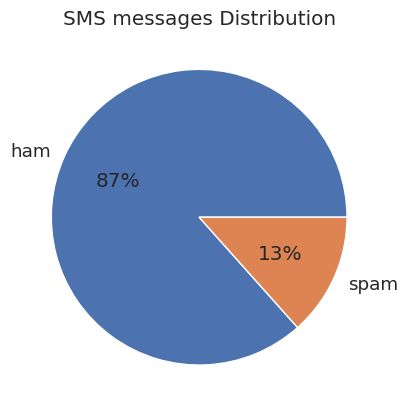

In [22]:
sms = pd.value_counts(df["Class"], sort=True)
sms.plot(kind="pie", labels=["ham", "spam"], autopct="%1.0f%%")

plt.title("SMS messages Distribution")
plt.ylabel("")
plt.show()

Above 87% of these SMS  messages are ham (legitimate) and 13% of them are spam.


Length of text messages:

In [23]:
df['length'] = df.Text.apply(len)
df.head()

,Class,Text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


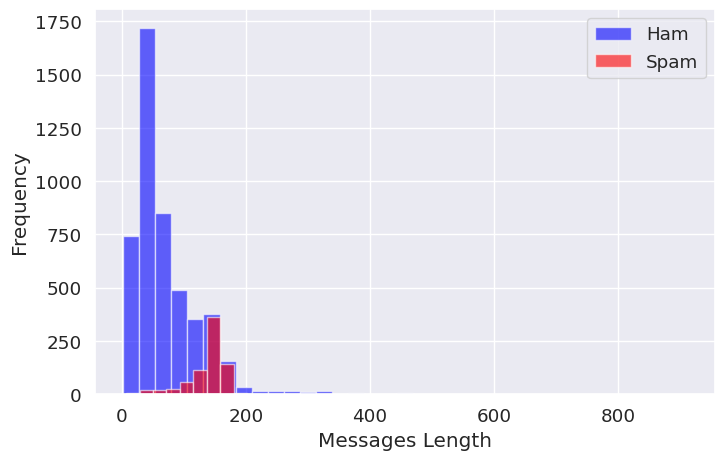

In [24]:
plt.figure(figsize=(8, 5))
df[df.Class == 0].length.plot(bins=35, kind='hist', color='blue', label='Ham', alpha=0.6)
df[df.Class == 1].length.plot(kind='hist', color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel("Messages Length");

Now I check if the length has an influence on messages spam or ham:

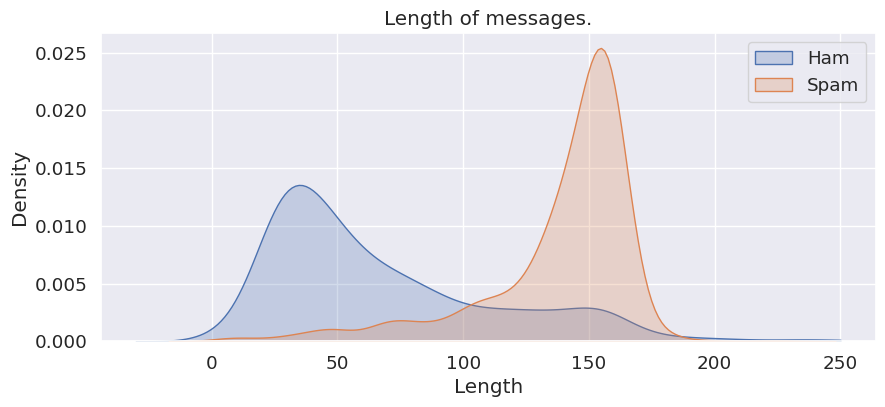

In [25]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(df.loc[df.Class == 0, "length"], shade=True, label="Ham", clip=(-50, 250),)
sns.kdeplot(df.loc[df.Class == 1, "length"], shade=True, label="Spam")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of messages.",
)
ax.legend(loc="upper right")
plt.show()

As one can notice the spam messages are longer than ham ones (that is normal due to the number of words) and  have around 150 characters.

### Text Pre-processing

In the next step I clean text, remove stop words and apply stemming operation for each line of text:

In [26]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['a', 'and', 'before', 'd', "don't", "hadn't", "he'll", 'i', 'it', 'ma', 'needn', 'once', 're', 'shouldn', 'the', "they'll", 'up', 'were', 'whom', "you'd"]


In [27]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [28]:
df['Text'] = df['Text'].apply(clean_text)
df['Text'] = df['Text'].apply(remove_stopwords)
df['Text'] = df['Text'].apply(stemmer)

In [29]:
df.head()

,Class,Text,length
0,0,go jurong point crazi avail bugi n great world...,111
1,0,ok lar joke wif u oni,29
2,1,free entri wkli comp win fa cup final tkt st m...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah think goe usf live around though,61


In [30]:
print(df['Text'].apply(lambda x: len(x.split(' '))).sum())

50290


## BERT model

BERT (Bidirectional Encoder Representations from Transformers) is a pretrained NLP algorithm devolped by Google AI. BERT is a bidirectionally trained of Transformer an attention model use to language modelling. So it can have a deeper sense of language context and flow compared to the single-direction language models. BERT model instead of predicting the next word in a sequence makes use of a novel technique called Masked LM (MLM). It relies on randomly masks words in the sentence and then it tries to predict them. Unlike the previous language models, it takes both the previous and next tokens into account at the same time. This is a contrast to previous LSTM based models combined a text sequence left-to-right and right-to-left.

In the first step I will make tokenization on our dataset. Tokenization will allow to feed batches of sequences into the model at the same time.

To do the tokenization of the datasets I choose a pre-trained model  (`bert-large-uncased`) from the Huggingface Transformers library and I load it.

In [31]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-large-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

 In the Transformers library is available many different BERT models and I use the „TFBertModel” model (bert-base-uncased).

In [32]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Spliting the data into train and test sets:

In [33]:
X = df['Text']
y = df['Class']

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

The function which allows to encode the dataset with BERT tokenizer. The maximum sentence length is 64 (maxlen).

In [41]:
def encode(text, maxlen):
  input_ids=[]
  attention_masks=[]

  for row in text:
    encoded = tokenizer.encode_plus(
        row,
        add_special_tokens=True,
        max_length=maxlen,
        pad_to_max_length=True,
        return_attention_mask=True,
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids),np.array(attention_masks)


Based on this encodings for the training and testing datasets are generated as follows:

In [42]:


X_train_input_ids, X_train_attention_masks = encode(X_train.values, maxlen=64)
X_test_input_ids, X_test_attention_masks = encode(X_test.values, maxlen=64)

## Build the model

I create a model using BERT model and then add two Dense layers with Dropout layer.

In [49]:
def build_model(bert_model):
   input_word_ids = tf.keras.Input(shape=(64,),dtype='int32')
   attention_masks = tf.keras.Input(shape=(64,),dtype='int32')

   sequence_output = bert_model([input_word_ids,attention_masks])
   output = sequence_output[1]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

   model = tf.keras.models.Model(inputs = [input_word_ids,attention_masks], outputs = output)
   model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

   return model

In [47]:
def build_model(bert_model):
    input_word_ids = Input(shape=(64,), dtype=tf.int32)
    attention_masks = Input(shape=(64,), dtype=tf.int32)

    # Calling bert_model with input_word_ids and attention_masks, and token_type_ids=None
    sequence_output = bert_model([input_word_ids, attention_masks], token_type_ids=None)
    output = sequence_output[1]  # Access the pooled output ([1])
    output = Dense(32, activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs=[input_word_ids, attention_masks], outputs=output)
    model.compile(Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [50]:
model = build_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 64, 76                                           
                             8),                                                              

I set class weights for the loss function to adjust for class imbalance. 'Spam' variable is set to weight 8x more.

I train the model for 5 epoch:

In [51]:
class_weight = {0: 1, 1: 8}

In [ ]:
history = model.fit(
    [X_train_input_ids, X_train_attention_masks],
    y_train,
    batch_size=32,
    epochs=5,
    validation_data=([X_test_input_ids, X_test_attention_masks], y_test),
    class_weight=class_weight)

Epoch 1/5
140/140 [==============================] - 103s 439ms/step - loss: 1.3867 - accuracy: 0.1710 - val_loss: 0.7519 - val_accuracy: 0.1435
Epoch 2/5
140/140 [==============================] - 58s 412ms/step - loss: 1.3246 - accuracy: 0.1317 - val_loss: 0.7794 - val_accuracy: 0.1435
Epoch 3/5
140/140 [==============================] - 58s 415ms/step - loss: 1.3240 - accuracy: 0.1317 - val_loss: 0.7648 - val_accuracy: 0.1435
Epoch 4/5
 72/140 [==============>...............] - ETA: 26s - loss: 1.2998 - accuracy: 0.1259

Visualization of training:

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Predictions on a test set:

In [ ]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_masks], y_test)
print('Test accuracy :', accuracy)

35/35 [==============================] - 5s 131ms/step - loss: 0.7470 - accuracy: 0.1489
Test accuracy : 0.14887891709804535


In [ ]:
#save model
model.save_weights('bert_model')

## Summary

For the analysis I have used a pretrained BERT model to resolve classification problem.  After trained model I have achieved an accuracy on the test set equal to 98 % and it is a very good result in comparison to previous Machine Learning models that I have used (e.g. Logistic Regression).

In [ ]:

# Example prediction
example_text = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005."
input_ids, attention_mask = encode(example_text, maxlen=64)

prediction = model.predict([input_ids, attention_mask])
print(f"Prediction for '{example_text}': {prediction[0][0]}") # Probability of being spam

# Interpret the prediction
threshold = 0.5 # You might adjust this threshold depending on your specific needs
if prediction[0][0] > threshold:
  print("Predicted as SPAM")
else:
  print("Predicted as HAM")

3/3 [==============================] - 4s 89ms/step
Prediction for 'Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.': 0.5364017486572266
Predicted as SPAM


In [ ]:
# # prompt: how to load and use this model for predictions with example

# import tensorflow as tf
# from transformers import BertTokenizer, TFBertModel
# import numpy as np

# # Load the tokenizer and the BERT model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# # Function to encode text using the tokenizer
# def encode(text, maxlen):
#     input_ids = []
#     attention_masks = []
#     encoded = tokenizer.encode_plus(
#         text,
#         add_special_tokens=True,
#         max_length=maxlen,
#         pad_to_max_length=True,
#         return_attention_mask=True,
#     )
#     input_ids.append(encoded['input_ids'])
#     attention_masks.append(encoded['attention_mask'])
#     return np.array(input_ids), np.array(attention_masks)

# # Rebuild the model architecture (same as in the training script)
# def build_model(bert_model):
#     input_word_ids = tf.keras.Input(shape=(64,), dtype='int32')
#     attention_masks = tf.keras.Input(shape=(64,), dtype='int32')
#     sequence_output = bert_model([input_word_ids, attention_masks])
#     output = sequence_output[1]
#     output = tf.keras.layers.Dense(32, activation='relu')(output)
#     output = tf.keras.layers.Dropout(0.2)(output)
#     output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
#     model = tf.keras.models.Model(inputs=[input_word_ids, attention_masks], outputs=output)
#     model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# model = build_model(bert_model)

# # Load the saved weights
# model.load_weights('bert_model')

# # Example prediction
# example_text = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005."
# input_ids, attention_mask = encode(example_text, maxlen=64)

# prediction = model.predict([input_ids, attention_mask])
# print(f"Prediction for '{example_text}': {prediction[0][0]}") # Probability of being spam

# # Interpret the prediction
# threshold = 0.5 # You might adjust this threshold depending on your specific needs
# if prediction[0][0] > threshold:
#   print("Predicted as SPAM")
# else:
#   print("Predicted as HAM")
